# TfIdf BOW
We take snippets of books and **train a tf-idf BOW model** on them.

Next, we explore **most similar documents** to 2 selected documents. Do these documents come from the same author? Do they have same genre?

In the following, we project the document vectors to 2D using **PCA** and **t-SNE** and plot them. Are documents written by the same author close to each other? Can we observe clusters based on genres?


In [1]:
import gensim # sudo pip3 install gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim import similarities
import os
import sys
import collections
import numpy as np 
import random
import pickle
import multiprocessing
import pandas as pd
import zipfile

import logging
logging.getLogger().setLevel('INFO')

sys.path.append('..')

from src.utils import load_corpus

cores = multiprocessing.cpu_count()

RES = '../res/'
SAMPLE_BOOKS_CLEAN_FOLDER = '../res/books_clean'
TOKENIZED_DOCS_FOLDER = '../res/tokenized_docs'

SAMPLE_BOOKS_CLEAN_URL = "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip"
BOOKS_ZIP_FILENAME = '../res/books_sample_clean.zip'

In [2]:
SKIP_FIRST_N_WORDS = 500
WORDS_IN_DOCUMENT = [500,2000]
SAMPLES_PER_DOCUMENT = 3

Load the Tagged Documents and pickle the whole corpus (might cause problem for big files).

In [3]:
filepath = '../res/documents_{}_{}_{}.pkl'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT)

if not os.path.exists(filepath):
    # create documents out of the tokens
    documents = list(load_corpus(TOKENIZED_DOCS_FOLDER, 
                                 skip_first_n_words=SKIP_FIRST_N_WORDS, 
                                 words_in_document=WORDS_IN_DOCUMENT,
                                samples_per_document=SAMPLES_PER_DOCUMENT,
                                random_seed=42))
    # save the list of documents
    pickle.dump(documents, open(filepath,'wb'))
else:
    # list of documents is already saved, load it
    documents = pickle.load(open(filepath,'rb'))
print("\nNumber of documents: {}".format(len(documents)))


Number of documents: 50023


In [4]:
%%time
dct = Dictionary((d for d,i in documents))  # fit dictionary
dct.filter_extremes(no_below=30)
print("Vocabulary size: {}".format(len(dct)))

Vocabulary size: 33492
CPU times: user 52.6 s, sys: 196 ms, total: 52.8 s
Wall time: 52.9 s


convert dataset to BoW format

In [5]:
corpus = [dct.doc2bow(d) for d,i in documents]

fit model

In [6]:
model = TfidfModel(corpus)

As the documents are 0 indexed in Doc2Vec, we create a lookup table to keep track of document ids.

In [7]:
lookup_table = dict()
for n, (tokens, key) in enumerate(documents):
    lookup_table[key[0]] = n
    
book_ids = np.array(list(lookup_table.keys()))
book_ids_catalog = [int(b.split('_')[0]) for b in book_ids]

In [8]:
docvecs = [model[corpus[lookup_table[b]]] for b in book_ids]
docvecs = gensim.matutils.corpus2csc(docvecs).T.toarray()

### Fetch metadata catalog
- as we have multiple documents per book, we duplicate catalog entries for each document

In [9]:
from src.utils import load_catalog
metadata_catalog_0 = load_catalog()
metadata_catalog_0 = metadata_catalog_0[metadata_catalog_0.index.isin(book_ids_catalog)]

metadata_catalog = pd.DataFrame(columns=metadata_catalog_0.columns, index=book_ids)

for b in book_ids:
    metadata_catalog.loc[b] = metadata_catalog_0.loc[int(b.split('_')[0])]
print(metadata_catalog.shape)
metadata_catalog.head(5)

(50023, 10)


,author,title,downloads,formats,type,LCC,subjects,authoryearofbirth,authoryearofdeath,language
38254_0,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_1,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_2,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
1069_0,"Zola, Émile",Four Short Stories By Emile Zola,275,{'application/x-mobipocket-ebook': 'http://www...,Text,{PQ},"{France -- Social life and customs -- Fiction,...",1840,1902,[en]
1069_1,"Zola, Émile",Four Short Stories By Emile Zola,275,{'application/x-mobipocket-ebook': 'http://www...,Text,{PQ},"{France -- Social life and customs -- Fiction,...",1840,1902,[en]


# Most similar texts and typical words for a document

In [10]:
import wordcloud
from matplotlib import pyplot as plt

metadata_simple = metadata_catalog[['author','title','subjects']]
pd.set_option('display.max_colwidth', -1)
n_most_sim_docs = 10
# compute similarity index
index = similarities.SparseMatrixSimilarity(model[corpus], num_features=len(dct))

In [11]:
def similarities_table(model, index, catalog, tokens, n_most_sim_docs=10):
    vector = model[tokens]
    sims = index[model[vector]]
    result = catalog.copy().loc[[b for b in book_ids]]
    result['score'] = sims
    result['score'] = result['score'].round(3)
    result.sort_values('score', inplace=True, ascending=False)
    return result[:n_most_sim_docs]

In [12]:
def get_word_tfidf_scores(model, tokens, dct):
    """
    returns sorted list of tuples with words and their tfidf scores
    """
    idword_score_pairs = np.array(model[tokens])
    idword_score_pairs_sorted = idword_score_pairs[idword_score_pairs[:,1].argsort()][::-1]
    words_score_pairs = [ (dct[idx], tfidf_score) for idx,tfidf_score in idword_score_pairs_sorted]
    return words_score_pairs   

## The Adventures of Sherlock Holmes

In [13]:
doc_id = '1661_0'
n_typical_words=10

### Most typical words

0.509 holmes
0.415 mccarthy
0.269 turner
0.212 sherlock
0.159 james
0.088 averse
0.083 father
0.081 victoria
0.079 favour
0.078 blow


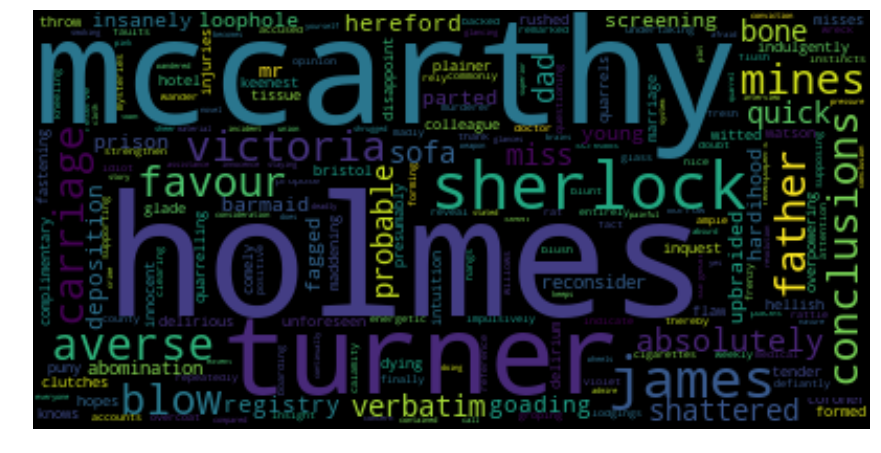

In [14]:
tokens = corpus[lookup_table[doc_id]]
word_tfidf_scores = get_word_tfidf_scores(model, tokens, dct)

for word, tfidf_score in word_tfidf_scores[:n_typical_words]:
    print(np.round(tfidf_score,3), word)

wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(word_tfidf_scores))

plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most similar documents

In [15]:
similarities_table(model=model, index=index, catalog=metadata_simple, tokens=tokens, n_most_sim_docs=n_most_sim_docs)

,author,title,subjects,score
1661_0,"Doyle, Arthur Conan",The Adventures of Sherlock Holmes,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories, English}",0.948
2347_0,"Doyle, Arthur Conan",The Adventure of the Dying Detective,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories}",0.452
32784_0,"Shaver, Richard S.",The Dark Goddess,"{Short stories, Human-alien encounters -- Fiction, Science fiction, Love stories}",0.429
2347_1,"Doyle, Arthur Conan",The Adventure of the Dying Detective,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories}",0.424
2347_2,"Doyle, Arthur Conan",The Adventure of the Dying Detective,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories}",0.417
27523_2,None,Masterpieces of Mystery in Four Volumes: Detective Stories,"{Short stories, Ghost stories, Detective and mystery stories}",0.412
20559_1,"Bangs, John Kendrick","R. Holmes & Co.: Being the Remarkable Adventures of Raffles Holmes, Esq., Detective and Amateur Cracksman by Birth","{Hornung, E. W. (Ernest William), 1866-1921 -- Parodies, imitations, etc., Private investigators -- England -- Fiction, Criminals -- Fiction, Detective and mystery stories, England -- Fiction, Doyle, Arthur Conan, Sir, 1859-1930 -- Parodies, imitations, etc.}",0.409
32784_1,"Shaver, Richard S.",The Dark Goddess,"{Short stories, Human-alien encounters -- Fiction, Science fiction, Love stories}",0.392
2346_0,"Doyle, Arthur Conan",The Adventure of the Bruce-Partington Plans,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories}",0.390
2348_1,"Doyle, Arthur Conan",The Disappearance of Lady Frances Carfax,"{Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories}",0.379


## Pride and Prejudice

In [16]:
doc_id = '1342_0'
n_typical_words=10

### Most typical words

0.494 bennet
0.329 elizabeth
0.269 darcy
0.24 ladyship
0.202 nephew
0.157 catherine
0.145 miss
0.116 copse
0.115 report
0.095 frankness


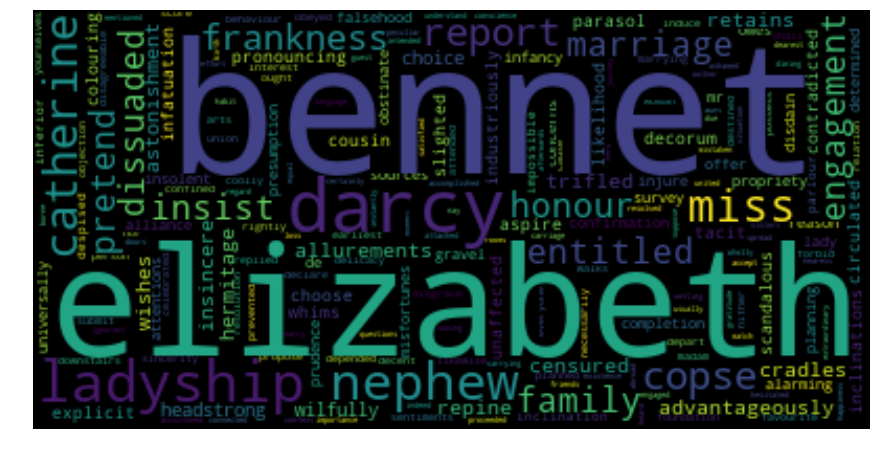

In [17]:
tokens = corpus[lookup_table[doc_id]]
word_tfidf_scores = get_word_tfidf_scores(model, tokens, dct)

for word, tfidf_score in word_tfidf_scores[:n_typical_words]:
    print(np.round(tfidf_score,3), word)

wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(word_tfidf_scores))

plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most similar documents

In [18]:
similarities_table(model=model, index=index, catalog=metadata_simple, tokens=tokens, n_most_sim_docs=n_most_sim_docs)

,author,title,subjects,score
1342_0,"Austen, Jane",Pride and Prejudice,"{Sisters -- Fiction, Young women -- Fiction, Social classes -- Fiction, England -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction}",0.944
37431_1,"MacKaye, Steele, Mrs.","Pride and Prejudice, a play founded on Jane Austen's novel","{Courtship -- Drama, Young women -- Drama, Sisters -- Drama, Domestic drama, Social classes -- Drama, England -- Drama, Fairy tales -- United States, Bennet, Elizabeth (Fictitious character) -- Drama}",0.625
2829_2,"Jerome, Jerome K. (Jerome Klapka)",Fanny and the Servant Problem,"{Comedies, Married people -- Drama, English drama}",0.502
37431_0,"MacKaye, Steele, Mrs.","Pride and Prejudice, a play founded on Jane Austen's novel","{Courtship -- Drama, Young women -- Drama, Sisters -- Drama, Domestic drama, Social classes -- Drama, England -- Drama, Fairy tales -- United States, Bennet, Elizabeth (Fictitious character) -- Drama}",0.497
42671_1,"Austen, Jane",Pride and Prejudice,"{Sisters -- Fiction, Young women -- Fiction, Social classes -- Fiction, England -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction}",0.485
42671_0,"Austen, Jane",Pride and Prejudice,"{Sisters -- Fiction, Young women -- Fiction, Social classes -- Fiction, England -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction}",0.462
1342_2,"Austen, Jane",Pride and Prejudice,"{Sisters -- Fiction, Young women -- Fiction, Social classes -- Fiction, England -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction}",0.462
43741_0,"Brinton, Sybil G.",Old Friends and New Fancies: An Imaginary Sequel to the Novels of Jane Austen,"{Courtship -- Fiction, Mate selection -- Fiction, England -- Social life and customs -- 18th century -- Fiction}",0.451
37431_2,"MacKaye, Steele, Mrs.","Pride and Prejudice, a play founded on Jane Austen's novel","{Courtship -- Drama, Young women -- Drama, Sisters -- Drama, Domestic drama, Social classes -- Drama, England -- Drama, Fairy tales -- United States, Bennet, Elizabeth (Fictitious character) -- Drama}",0.438
1342_1,"Austen, Jane",Pride and Prejudice,"{Sisters -- Fiction, Young women -- Fiction, Social classes -- Fiction, England -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction}",0.427


# Visualization of docvecs in 2d using PCA and t-SNE

In [19]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

import itertools
markers = ['o','v','^','s','P','*','h','x','D']

## Authors

Display most common authors along with number of books in the corpus.

In [20]:
author_counts = collections.Counter(metadata_catalog.author)
author_counts.most_common(15)

[(None, 1855),
 ('Shakespeare, William', 493),
 ('Fenn, George Manville', 366),
 ('Kingston, William Henry Giles', 354),
 ('Meredith, George', 324),
 ('Various', 321),
 ('Jacobs, W. W. (William Wymark)', 318),
 ('Balzac, Honoré de', 306),
 ('Anonymous', 254),
 ('Ballantyne, R. M. (Robert Michael)', 243),
 ('Howells, William Dean', 225),
 ('James, Henry', 186),
 ('Le Queux, William', 183),
 ('Molesworth, Mrs.', 168),
 ('Harte, Bret', 162)]

Select 10 most common authors (excluding the authors *None*, *Various* and *Anonymous*).

In [21]:
n_authors = 10

selected_authors = [author for author, count in author_counts.most_common()
                           if author != None and author not in ('Various','Anonymous')]
selected_authors = selected_authors[:n_authors]
for author in selected_authors:
    print(author)

Shakespeare, William
Fenn, George Manville
Kingston, William Henry Giles
Meredith, George
Jacobs, W. W. (William Wymark)
Balzac, Honoré de
Ballantyne, R. M. (Robert Michael)
Howells, William Dean
James, Henry
Le Queux, William


Initialize variable `authors` that contains the author's name if the author is in `selected_authors`. Put 'Other' otherwise.

In [22]:
authors = metadata_catalog.loc[[b for b in book_ids]].author
authors.where(authors.isin(selected_authors), 'Other', inplace=True)

selected_author_mask = authors != 'Other'
authors_selected = reduced = authors[selected_author_mask]

### PCA

In [28]:
%%time
pca = IncrementalPCA(2, batch_size = 1000)
docvecs_pca = pca.fit_transform(docvecs)

In [29]:
n = len(authors.unique())
author_colors = plt.cm.Set1(np.linspace(0, 1, n))
author_markers = itertools.cycle(markers)
author_color_marker_dict = {a : (author_colors[n], next(author_markers)) for n,a in enumerate(authors.unique())}

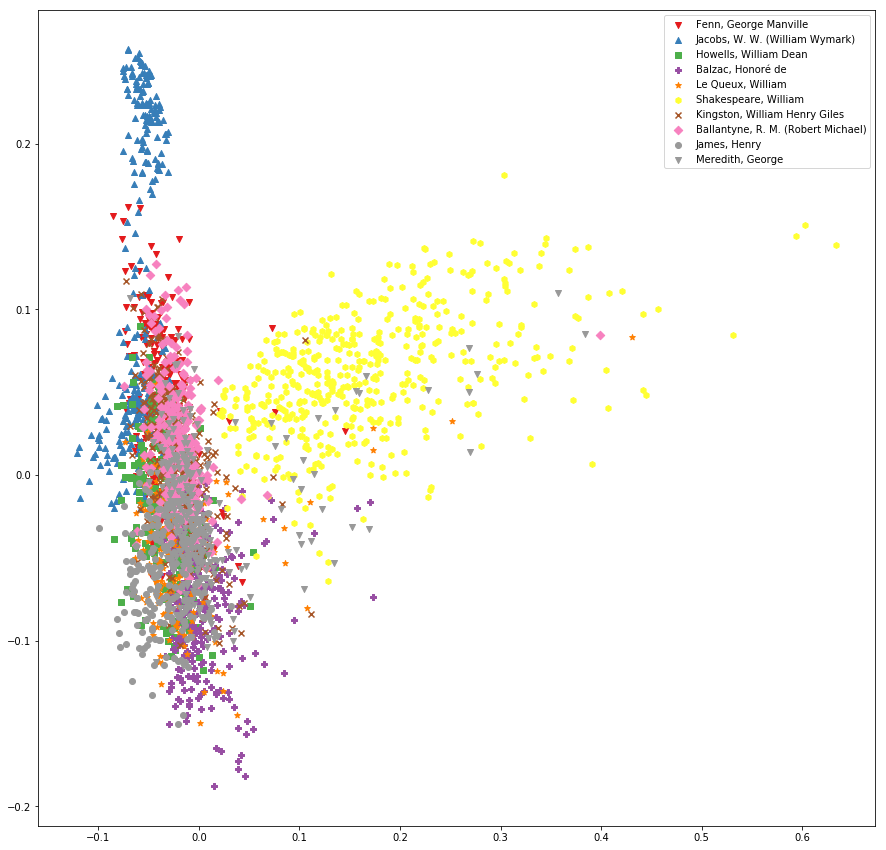

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_pca[authors == author, 0]
    y = docvecs_pca[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

In [31]:
%%time
pca_n = IncrementalPCA(50, batch_size = 1000)
docvecs_pca_n = pca_n.fit_transform(docvecs)

In [ ]:
%%time
tsne = TSNE(n_components=2)
docvecs_tsne = tsne.fit_transform(docvecs_pca_n)

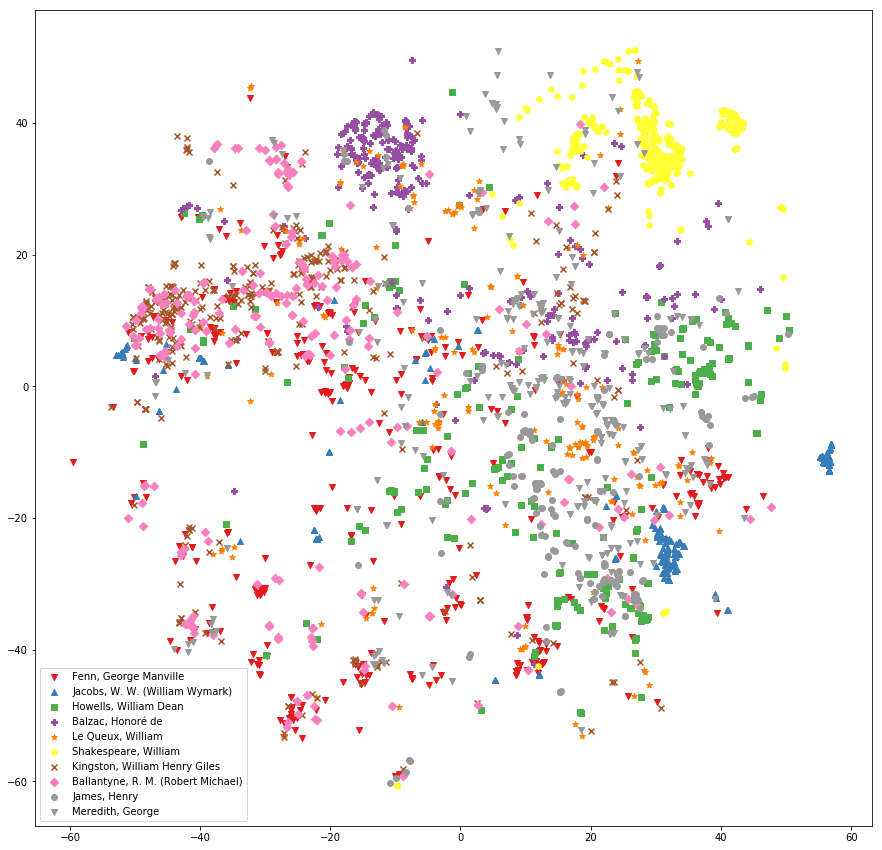

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_tsne[authors == author, 0]
    y = docvecs_tsne[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

## Genres

In [23]:
c = [subject.lower().strip() for subjects in metadata_catalog.subjects for subject in subjects]
c2 = [simple_subject.strip() for complex_subject in c for simple_subject in complex_subject.split('--')]
#c2 = [complex_subject.split('--')[0] for complex_subject in c]
#c3 = [simple_subject.strip() for complex_subject in c2 for simple_subject in complex_subject.split(',')]
#c3 = [complex_subject.split(',')[0] for complex_subject in c2]

In [24]:
collections.Counter(c2).most_common(20)

[('fiction', 43785),
 ('juvenile fiction', 31401),
 ('social life and customs', 3743),
 ('19th century', 3687),
 ('england', 3627),
 ('history', 3563),
 ('short stories', 3431),
 ('drama', 3369),
 ('conduct of life', 3332),
 ('science fiction', 3173),
 ('translations into english', 2648),
 ('poetry', 2148),
 ('united states', 1773),
 ('great britain', 1663),
 ('adventure stories', 1548),
 ('love stories', 1440),
 ('detective and mystery stories', 1361),
 ('biography', 1260),
 ('western stories', 1134),
 ('young women', 1116)]

Chosing genres to classify on. Didn't take *fiction* and *juvenile fiction* as these might be too general.

In [25]:
selected_genres = ['short stories',
                  'science fiction',
                  'history',
                  'conduct of life',
                  'drama',
                  'poetry',
                  'detective and mystery stories',
                  'biography',
                  'western stories',
                  'children\'s stories']

Documents having exactly one genre out of `specified genres` are given that genre. Documents having more than one of genres in `selected genres` or none of them are set to *other* and will be not used for classifying.

In [26]:
def modify_genres(genre_set):
    if len(genre_set) == 0:
        return set()
    result_set = set()
    for s in genre_set:
        result_set = result_set.union(set([x.lower().strip() for x in s.split('--')]))
    return result_set

metadata_catalog['modified_genres'] = metadata_catalog.subjects.apply(modify_genres)

genres = metadata_catalog['modified_genres'].apply(
    lambda x: list(x.intersection(selected_genres))[0]
      if len(x.intersection(selected_genres))==1 else 'other')

selected_genre_mask = genres != 'other'
genres_selected = authors[selected_genre_mask]
genres.value_counts()

other                            35361
history                          2663 
conduct of life                  1937 
short stories                    1785 
poetry                           1744 
science fiction                  1707 
detective and mystery stories    1304 
drama                            1096 
western stories                  1062 
biography                        843  
children's stories               521  
Name: modified_genres, dtype: int64

In [27]:
NUM_COLORS = len(genres.unique())+1

cm = plt.get_cmap('Set1')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

### PCA

In [49]:
n = len(selected_genres)
n_samples_per_genre = 100


genre_colors = plt.cm.Set1(np.linspace(0, 1, n))
genre_markers = itertools.cycle(markers)
print(genre_markers)
genre_color_marker_dict = {g : (genre_colors[n], next(genre_markers)) for n,g in enumerate(selected_genres)}

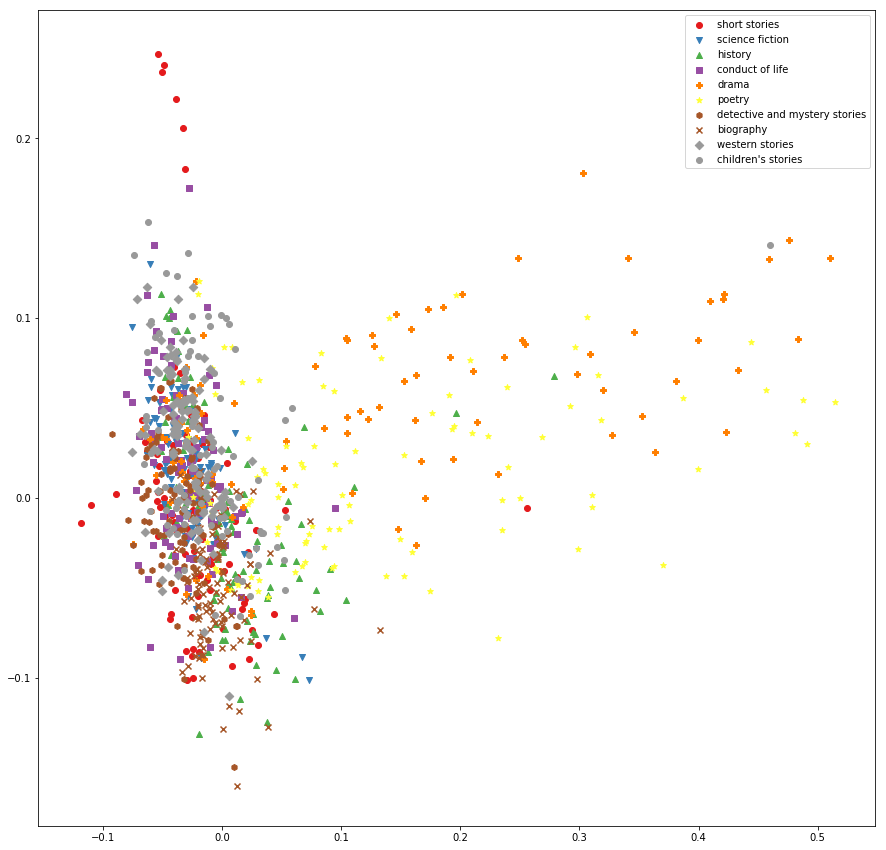

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_pca[genres == genre, 0][:n_samples_per_genre]
    y = docvecs_pca[genres == genre, 1][:n_samples_per_genre]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

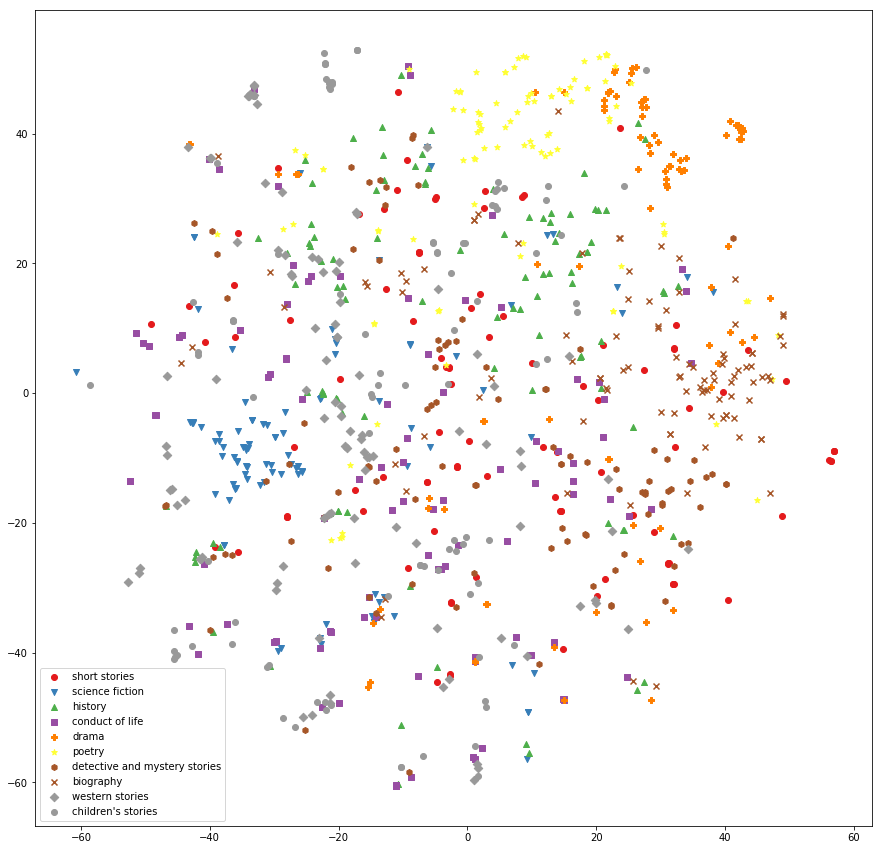

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_tsne[genres == genre, 0][:n_samples_per_genre]
    y = docvecs_tsne[genres == genre, 1][:n_samples_per_genre]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

# CLASSIFIERS

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [30]:
classifiers = {'Logistic Regression': LogisticRegression(class_weight='balanced'),
              'Random Forest': RandomForestClassifier(n_estimators=500, 
                                     class_weight='balanced', 
                                     min_samples_leaf=10, 
                                     max_features='sqrt', 
                                     max_depth=8),
              'Gaussian Naive Bayes': GaussianNB(),
              'KNN 5' : KNeighborsClassifier(5),
              'KNN 11 distance weights' : KNeighborsClassifier(11, weights='distance'),
              'KNN 9' :KNeighborsClassifier(9),
              #'SVM C=1': SVC(class_weight='balanced', C=1),
              #'SVM C=10': SVC(class_weight='balanced', C=10),
              #'SVM C=100': SVC(class_weight='balanced', C=100)
}
classifiers = {'Logistic Regression': LogisticRegression(class_weight='balanced'),
               'Gaussian Naive Bayes': GaussianNB()
              }
               

## Author

In [54]:
X_train, X_test, y_train, y_test, ids_train, ids_test = \
    train_test_split(docvecs[selected_author_mask], authors[selected_author_mask], book_ids[selected_author_mask])
    
labels = sorted(authors[selected_author_mask].unique())

In [56]:
%%time
author_results = pd.DataFrame(columns=['f1-macro on train','f1-macro on test','accuracy on train','accuracy on test'])

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    f1_score_macro_train = f1_score(y_train, y_pred_train, average='macro')
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_score_macro_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    author_results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test]

author_results.sort_values(['f1-macro on test'], ascending=False, inplace=True)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-macro on train,f1-macro on test,accuracy on train,accuracy on test
Logistic Regression,0.996258,0.952403,0.995996,0.956
Random Forest,0.963774,0.883448,0.963078,0.897333
Gaussian Naive Bayes,1,0.826811,1,0.845333
KNN 11 distance weights,1,0.791682,1,0.816
KNN 5,0.888686,0.780969,0.897687,0.808
KNN 9,0.854518,0.779071,0.867438,0.805333
SVM C=10,0.02187,0.0214286,0.122776,0.12
SVM C=100,0.02016,0.0175182,0.1121,0.096
SVM C=1,0.0111718,0.0125,0.0591637,0.0666667


In [ ]:
author_results

Select the best model

In [57]:
clf = classifiers[author_results.index[0]]
clf

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Show confusion matrix for the test set.

In [61]:
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), columns=labels, index=labels)

,"Ballantyne, R. M. (Robert Michael)","Balzac, Honoré de","Fenn, George Manville","Howells, William Dean","Jacobs, W. W. (William Wymark)","James, Henry","Kingston, William Henry Giles","Le Queux, William","Meredith, George","Shakespeare, William"
"Ballantyne, R. M. (Robert Michael)",49,0,3,0,0,0,6,0,1,1
"Balzac, Honoré de",0,72,0,0,0,0,0,0,1,0
"Fenn, George Manville",0,0,88,0,0,0,2,0,0,0
"Howells, William Dean",0,0,2,53,0,0,0,0,2,0
"Jacobs, W. W. (William Wymark)",0,0,2,0,76,0,0,0,0,0
"James, Henry",0,0,0,0,0,45,0,0,1,0
"Kingston, William Henry Giles",0,0,1,1,0,0,77,0,0,1
"Le Queux, William",0,1,1,0,0,2,0,45,1,0
"Meredith, George",0,0,0,0,0,0,0,0,71,1
"Shakespeare, William",0,0,0,3,0,0,0,0,0,141


## Genre

In [31]:
X_train, X_test, y_train, y_test, ids_train, ids_test = \
    train_test_split(docvecs[selected_genre_mask], genres[selected_genre_mask], book_ids[selected_genre_mask])

labels = sorted(genres[selected_genre_mask].unique())

In [32]:
%%time
genre_results = pd.DataFrame(columns=['f1-macro on train','f1-macro on test','accuracy on train','accuracy on test'])

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    f1_score_macro_train = f1_score(y_train, y_pred_train, average='macro')
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_score_macro_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    genre_results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test]

genre_results.sort_values(['f1-macro on test'], ascending=False, inplace=True)

CPU times: user 55.4 s, sys: 36.1 s, total: 1min 31s
Wall time: 1min 30s


In [36]:
genre_results

,f1-macro on train,f1-macro on test,accuracy on train,accuracy on test
Logistic Regression,0.889358,0.744387,0.886049,0.752591
Gaussian Naive Bayes,0.993407,0.474922,0.99227,0.512002


Select the best model

In [34]:
clf = classifiers[genre_results.index[0]]
clf

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Show confusion matrix for the test set.

In [35]:
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), columns=labels, index=labels)

,biography,children's stories,conduct of life,detective and mystery stories,drama,history,poetry,science fiction,short stories,western stories
biography,158,2,4,3,0,13,7,1,7,2
children's stories,1,76,38,0,2,5,2,1,4,3
conduct of life,3,19,364,12,1,29,6,6,23,17
detective and mystery stories,2,1,18,237,1,12,2,11,21,10
drama,7,2,5,1,233,7,16,0,1,2
history,31,3,55,16,12,462,17,5,32,22
poetry,28,6,2,0,5,10,384,4,4,3
science fiction,6,0,6,10,2,14,2,381,14,2
short stories,16,10,35,27,7,44,18,35,246,23
western stories,1,2,4,11,1,21,1,2,8,218


# SUMMARY:
- The **most similar documents** are usually documents written by the **same author** or having **similar genre**.
- We can observe **documents by one author** being **close to each other** in 2D when using either PCA or t-SNE dimensionality reduction
- Same genres also appear close together, however not as strong as for the authors
- Good classifier for 10 author and 10 genre classes turned out to be **One vs One Logistic Regression**:
  - **author classifier is close to perfect**
  - **genre classifier** is performing good but still has **minor room for improvement**.